# Genomic surveillance analysis in Germany

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
from genomicsurveillance.misc import ancestor_matrix, alias

## Download data
### Map
With zip codes for geo matching

In [3]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
if 'plz' not in locals():
    plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
    bland = plz.set_index("plz")['bundesland']

### Sequences
From RKI's Github

In [4]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60.5M  100 60.5M    0     0  12.7M      0  0:00:04  0:00:04 --:--:-- 16.1M
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22.8M  100 22.8M    0     0  11.3M      0  0:00:02  0:00:02 --:--:-- 16.2M
+ bash scripts/

In [5]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [6]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [7]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [8]:
df.reason.value_counts()

N                             577216
X                             339271
Y                              38366
A[B.1.617.2]                   35840
A[B.1.1.7]                     35832
                               ...  
A[E484K/N501Y/P681R]               0
A[E484E/N501N/P681P]               0
A[N501Y/E484K]                     0
A[KONTAKTMITENGL.MUTATION]         0
A[E484E/N501N/P681R]               0
Name: reason, Length: 232, dtype: int64

In [9]:
import re

In [10]:
df

,date,reason,processing_date,sending_pc,sequencing_pc,lineage,scorpio,bundesland
IMS_ID,,,,,,,,
IMS-10294-CVDP-00001,2021-01-14,X,2021-01-25,40225,40225,B.1.1.297,NaN,Nordrhein-Westfalen
IMS-10294-CVDP-00325,2020-11-08,X,2021-02-14,40225,40225,B.1.221,NaN,Nordrhein-Westfalen
IMS-10294-CVDP-00326,2020-11-08,X,2021-02-14,40225,40225,B.1.160,NaN,Nordrhein-Westfalen
IMS-10294-CVDP-00327,2020-11-08,X,2021-02-14,40225,40225,B.1.258,NaN,Nordrhein-Westfalen
IMS-10294-CVDP-00329,2020-11-09,X,2021-02-14,40225,40225,B.1.1.521,NaN,Nordrhein-Westfalen
...,...,...,...,...,...,...,...,...
IMS-10594-CVDP-441D54FB-2461-41C0-A574-6C8904DF751D,2022-08-17,Y,2022-09-05,55131,55131,BA.4.6,NaN,Rheinland-Pfalz
IMS-10594-CVDP-C16BEC12-A505-4AED-BA35-2DD98AAD2D3F,2022-08-17,Y,2022-09-05,55131,55131,BA.5.1.2,NaN,Rheinland-Pfalz
IMS-10594-CVDP-315A8797-7C80-4AF6-B5F2-F2C208EF921E,2022-08-16,Y,2022-09-05,55131,55131,BE.1.1,NaN,Rheinland-Pfalz


In [11]:
df.lineage[df.date > np.datetime64("today") - np.timedelta64(30, "D")].cat.remove_unused_categories().value_counts()

BA.5.2      3737
BA.5.1      3112
BA.5.2.1    2018
BE.1.1      1605
BF.7         699
            ... 
BA.2.72        1
BA.2.5         1
BA.2.38        1
BA.2.71        1
BA.2.36        1
Name: lineage, Length: 98, dtype: int64

In [77]:
start_date = "2021-01-01"
d = df.loc[df.date >= start_date,:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.remove_unused_categories().cat.add_categories(['Other'])
l = d.lineage.cat.categories#remove_unused_categories()

In [78]:
ba = [x for x in l if alias(x, anti_alias=True).startswith('B.1.1.529') ]
#ba

In [79]:
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
#d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2'] + ba),"lineage"] = "Other"
d.lineage = d.lineage.cat.remove_unused_categories()#.cat.add_categories(['BA.2.40'])
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage, dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[(i + 1) % genomes.shape[1] for i in range(genomes.shape[1])]]
genomes

lineage                       A.19  A.2.5  A.2.5.2  A.23.1  A.27  A.28  A.29  \
bundesland        date                                                         
Baden-Württemberg 2021-01-01     0      0        0       0     0     0     0   
                  2021-01-02     0      0        0       0     0     0     0   
                  2021-01-03     0      0        0       0     0     0     0   
                  2021-01-04     0      0        0       0     0     0     0   
                  2021-01-05     0      0        0       0     0     0     0   
...                            ...    ...      ...     ...   ...   ...   ...   
Thüringen         2022-09-11     0      0        0       0     0     0     0   
                  2022-09-12     0      0        0       0     0     0     0   
                  2022-09-13     0      0        0       0     0     0     0   
                  2022-09-15     0      0        0       0     0     0     0   
                  2022-09-16     0      0        0       0     0     0     0   

lineage                       AA.1  AF.1  AG.1  ...  BA.5.2.4  BA.5.2.5  \
bundesland        date                          ...                       
Baden-Württemberg 2021-01-01     0     0     0  ...         0         0   
                  2021-01-02     0     0     0  ...         0         0   
                  2021-01-03     0     0     0  ...         0         0   
                  2021-01-04     0     0     0  ...         0         0   
                  2021-01-05     0     0     0  ...         0         0   
...                            ...   ...   ...  ...       ...       ...   
Thüringen         2022-09-11     0     0     0  ...         0         0   
                  2022-09-12     0     0     0  ...         0         0   
                  2022-09-13     0     0     0  ...         0         0   
                  2022-09-15     0     0     0  ...         0         0   
                  2022-09-16     0     0     0  ...         0         0   

lineage                       BA.5.6.1  BE.1.2  BF.13  BF.9  BH.1  BK.1  XAJ  \
bundesland        date                                                         
Baden-Württemberg 2021-01-01         0       0      0     0     0     0    0   
                  2021-01-02         0       0      0     0     0     0    0   
                  2021-01-03         0       0      0     0     0     0    0   
                  2021-01-04         0       0      0     0     0     0    0   
                  2021-01-05         0       0      0     0     0     0    0   
...                                ...     ...    ...   ...   ...   ...  ...   
Thüringen         2022-09-11         0       0      0     0     0     0    0   
                  2022-09-12         0       0      0     0     0     0    0   
                  2022-09-13         0       0      0     0     0     0    0   
                  2022-09-15         0       0      0     0     0     0    0   
                  2022-09-16         0       0      0     0     0     0    0   

lineage                       A  
bundesland        date           
Baden-Württemberg 2021-01-01  0  
                  2021-01-02  0  
                  2021-01-03  0  
                  2021-01-04  0  
                  2021-01-05  0  
...                          ..  
Thüringen         2022-09-11  0  
                  2022-09-12  0  
                  2022-09-13  0  
                  2022-09-15  0  
                  2022-09-16  0  

[9968 rows x 710 columns]

In [80]:
with pd.option_context('display.max_rows', None,):
    print(genomes.sum(level=1).loc["2022-06-01":,[x for x in genomes.columns if x.startswith("BA.2.75")]])

lineage     BA.2.75  BA.2.75.1  BA.2.75.2  BA.2.75.5
date                                                
2022-06-01        0          0          0          0
2022-06-02        0          0          0          0
2022-06-03        1          0          0          0
2022-06-04        0          0          0          0
2022-06-05        0          0          0          0
2022-06-06        1          0          0          0
2022-06-07        0          0          0          0
2022-06-08        0          0          0          0
2022-06-09        0          0          0          0
2022-06-10        0          0          0          0
2022-06-11        0          0          0          0
2022-06-12        0          0          0          0
2022-06-13        0          0          0          0
2022-06-14        0          0          0          0
2022-06-15        0          0          0          0
2022-06-16        0          0          0          0
2022-06-17        0          0          0     

Text(0, 0.5, '14d log odds Aug 1-15 / Jul 15-30')

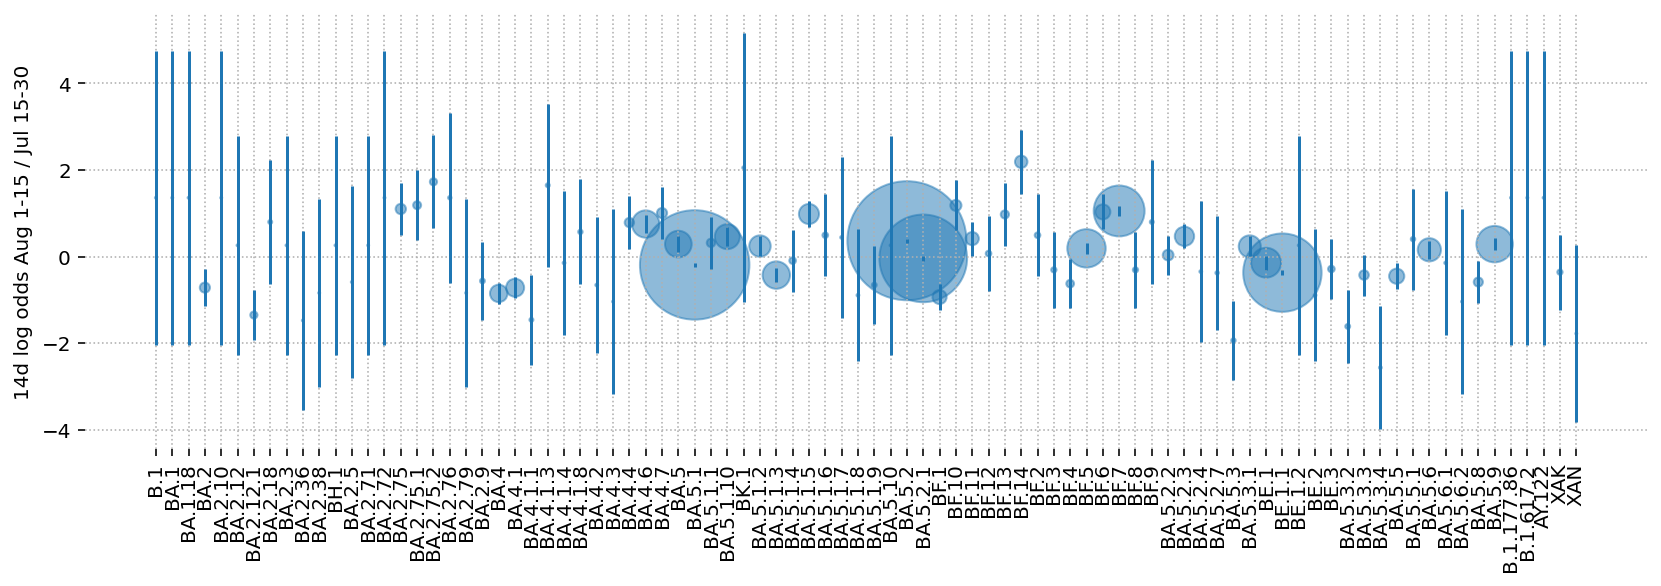

In [81]:
g = genomes.sum(level=1)
g.columns =  [alias(alias(x, anti_alias=True)) for x in g.columns]
h = g.iloc[-28:].sum(0) #+.5
i = g.iloc[-56:-28].sum(0) +.5
f = h[h>0]/i[h>0] * i.sum()/h.sum()
f.index = [alias(x, anti_alias=True) for x in f.index]
f = f.sort_index()
f.index = [alias(x) for x in f.index]
n = h[h>0]
e = np.sqrt(1./h[h>0] + 1./i[h>0] + 1./i.sum() + 1./h.sum())
#e.index = [alias(alias(x, anti_alias=True)) for x in e.index]
plt.figure(figsize=(14,4))
plt.scatter(f.index, np.log(f), s=n[f.index], alpha=0.5)
plt.errorbar(f.index, np.log(f), yerr=1.96*e[f.index], ls="")
_ = plt.xticks(rotation=90)
plt.ylabel("14d log odds Aug 1-15 / Jul 15-30")

Text(0, 0.5, 'Fold change')

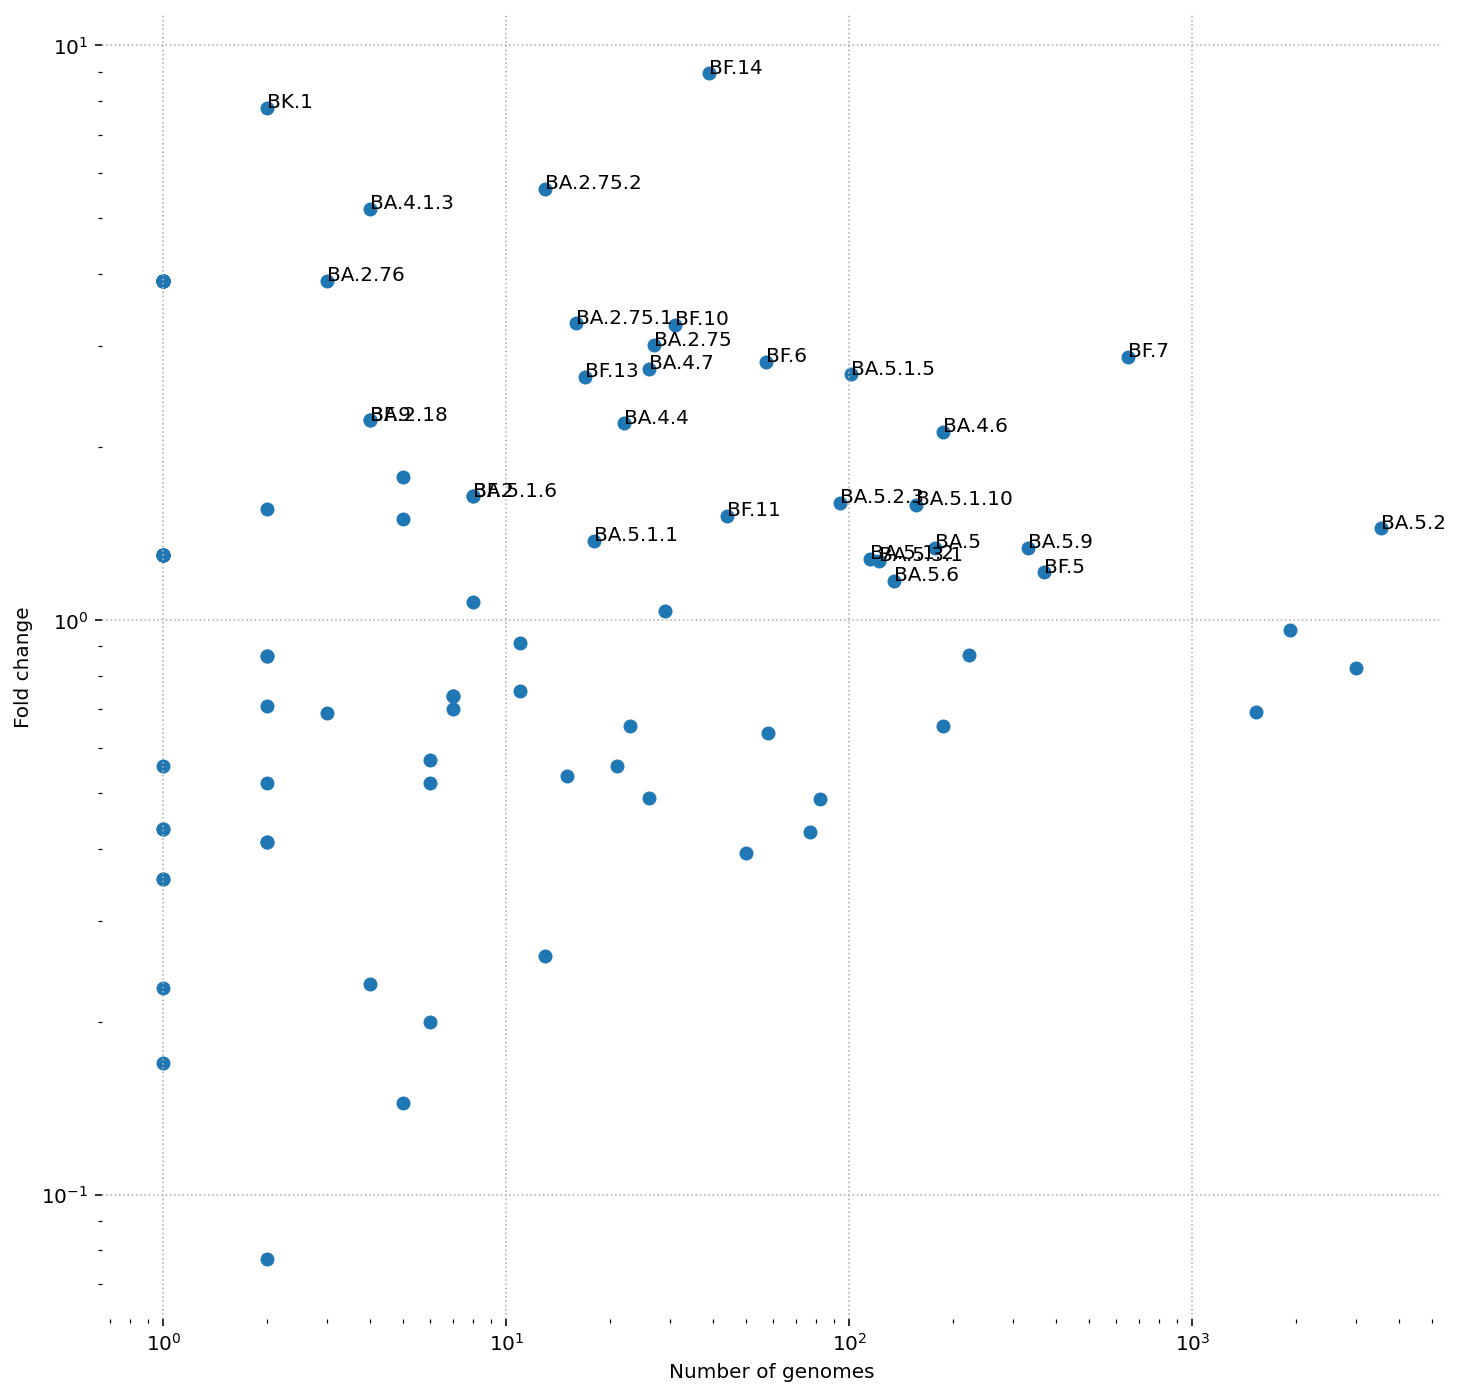

In [82]:
plt.figure(figsize=(12,12))
plt.scatter(n[f.index],f)
for l in f.index:
    if np.log(f[l]) > e[l]:
        plt.text(x=n[l], y=f[l], s=l)
plt.yscale('log')
plt.xlabel("Number of genomes")
plt.xscale('log')
plt.ylabel("Fold change")

(19083.0, 19282.15)

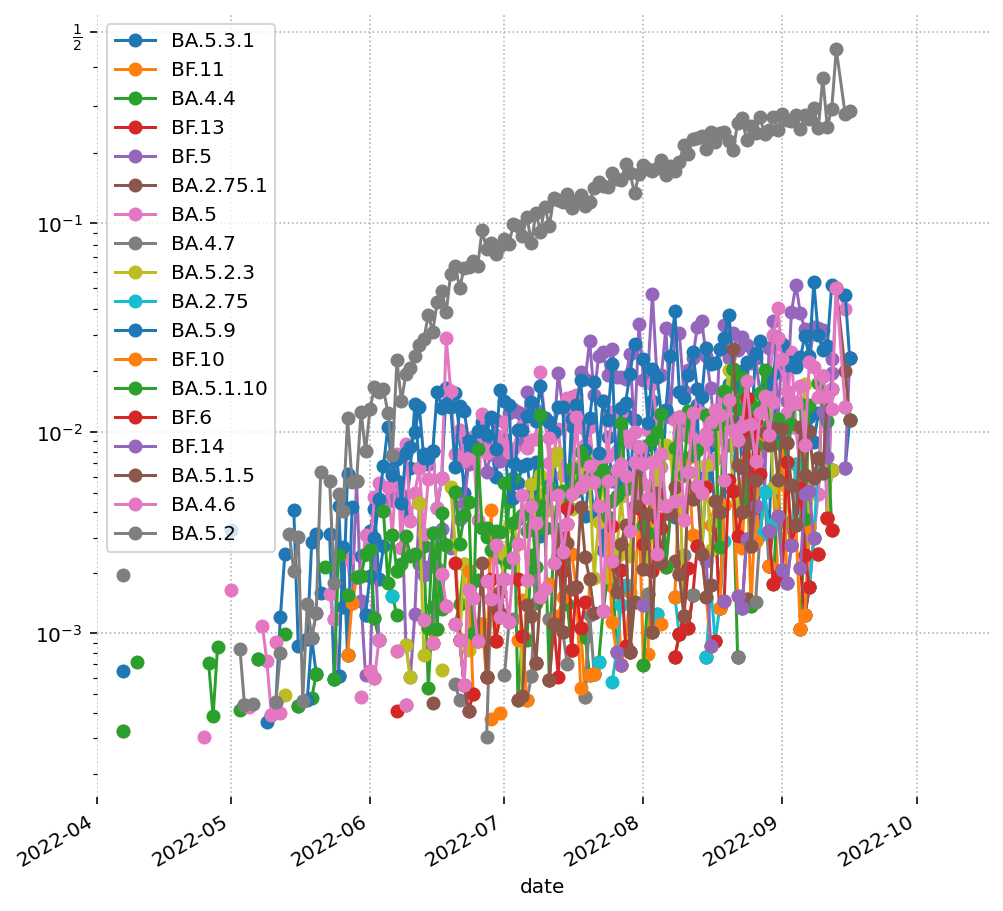

In [83]:
plt.figure(figsize=(8,8))
plt.set_cmap('tab20')
for i,v in enumerate((np.log(f)/e[f.index]).sort_values()[-20:-1].index.to_list() ):
    if g[v].sum()>=20:
        (g[v]/g.sum(1)+0).plot(label=v, ls="-", marker="o")
plt.yscale('logit')
#plt.show()
plt.legend()
plt.xlim(("2022-04-01",None))

In [84]:
genomes.loc["Sachsen", "2022-02-20"]["BA.4"] = 0 ## Remove outlier

In [85]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [86]:
genomes.loc[:,"BA.2.75"].sum(level=0)

bundesland
Baden-Württemberg         21
Bayern                     6
Berlin                     2
Brandenburg                2
Bremen                     0
Hamburg                    0
Hessen                     0
Mecklenburg-Vorpommern     2
Niedersachsen              5
Nordrhein-Westfalen        6
Rheinland-Pfalz            2
Saarland                   1
Sachsen                    2
Sachsen-Anhalt             0
Schleswig-Holstein         2
Thüringen                  0
Name: BA.2.75, dtype: int64

In [87]:
import importlib
importlib.reload(gs.utils)
importlib.reload(gs)
from genomicsurveillance.utils import preprocess_lineage_tensor

In [536]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [537]:
lineages = genomes.columns.to_list()

In [538]:
pattern=re.compile(r"[A-Z]+(\.\d+)*$")
pattern.match(lineages[1])

<re.Match object; span=(0, 5), match='A.2.5'>

In [539]:
vocs = ["B.1.1.529","BA.1","BA.1.1","BA.2","BA.4","BA.5","BA.5.2","BA.2.12.1","BA.2.75", "BA.2.75.1","BA.2.75.2","BA.4.6", "BF.7", "BF.11", "BF.13", "BF.14"] + ["B.1.1.7","B.1.351","P.1","AY.4"]

In [540]:
merged_lineages, G, _ = preprocess_lineage_tensor(lineage_tensor=G, 
                                                     lineage_list=[alias(x, anti_alias=True) for x in lineages], 
                                                     vocs=[alias(x, anti_alias=True) for x in lineages if x in vocs], #any([y in x for y in ["BA.4","BA.5","BA.2.12.1"]])], 
                                                     cutoff=100000)
merged_lineages

Dropped lineages []


['A',
 'B',
 'B.1.1.7',
 'B.1.1.28.1',
 'B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.1.529.5.2.1.14',
 'B.1.351',
 'B.1.617.2',
 'B.1.617.2.4',
 'XAB',
 'XAD',
 'XAF',
 'XAG',
 'XAH',
 'XAJ',
 'XAK',
 'XAL',
 'XAM',
 'XAN',
 'XAP',
 'XAS',
 'XAU',
 'XB',
 'XD',
 'XE',
 'XG',
 'XH',
 'XJ',
 'XM',
 'XV',
 'XW',
 'XZ']

In [541]:
G.sum((0,1))

array([6.93000e+02, 3.32820e+04, 9.77030e+04, 9.23000e+02, 1.52600e+03,
       5.74260e+04, 1.09756e+05, 2.59613e+05, 3.82700e+03, 5.20000e+01,
       2.70000e+01, 1.70000e+01, 6.23200e+03, 5.42000e+02, 6.86560e+04,
       3.13410e+04, 1.27800e+03, 1.15000e+02, 2.90000e+01, 4.90000e+01,
       1.97800e+03, 2.11451e+05, 2.71660e+04, 1.26000e+02, 9.00000e+01,
       2.00000e+00, 5.00000e+00, 5.00000e+00, 1.00000e+00, 1.23000e+02,
       9.70000e+01, 6.00000e+00, 2.50000e+01, 1.00000e+00, 1.00000e+00,
       2.00000e+00, 5.00000e+00, 1.00000e+00, 4.90000e+01, 4.60000e+01,
       3.00000e+00, 1.00000e+00, 3.75000e+02, 1.00000e+00, 5.30000e+01,
       3.00000e+00])

In [542]:
baseline = 'B'
o = [merged_lineages.index(x) for x in merged_lineages if x != baseline and not x.startswith("X")] + [merged_lineages.index(baseline)]
G = G[:,:,o]
merged_lineages = [merged_lineages[x] for x in o]
merged_lineages

['A',
 'B.1.1.7',
 'B.1.1.28.1',
 'B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.1.529.5.2.1.14',
 'B.1.351',
 'B.1.617.2',
 'B.1.617.2.4',
 'B']

In [543]:
merged_lineages_alias = [alias(x) for x in merged_lineages]
merged_lineages_alias

['A',
 'B.1.1.7',
 'P.1',
 'B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'B.1.351',
 'B.1.617.2',
 'AY.4',
 'B']

In [544]:
pd.DataFrame(G.reshape(-1,G.shape[2]), index=genomes.index, columns=merged_lineages_alias).sum(level=1).iloc[-28:].sum()

A               0.0
B.1.1.7         0.0
P.1             0.0
B.1.1.529       0.0
BA.1            2.0
BA.1.1          0.0
BA.2           49.0
BA.2.12.1      13.0
BA.2.75        27.0
BA.2.75.1      16.0
BA.2.75.2      13.0
BA.4          225.0
BA.4.6        187.0
BA.5         6269.0
BA.5.2       6149.0
BF.7          648.0
BF.11          44.0
BF.13          17.0
BF.14          39.0
B.1.351         0.0
B.1.617.2       2.0
AY.4            0.0
B               2.0
dtype: float64

In [545]:
dict(zip(merged_lineages_alias,G.sum((0,1))))

{'A': 693.0,
 'B.1.1.7': 97703.0,
 'P.1': 923.0,
 'B.1.1.529': 1526.0,
 'BA.1': 57426.0,
 'BA.1.1': 109756.0,
 'BA.2': 259613.0,
 'BA.2.12.1': 3827.0,
 'BA.2.75': 52.0,
 'BA.2.75.1': 27.0,
 'BA.2.75.2': 17.0,
 'BA.4': 6232.0,
 'BA.4.6': 542.0,
 'BA.5': 68656.0,
 'BA.5.2': 31341.0,
 'BF.7': 1278.0,
 'BF.11': 115.0,
 'BF.13': 29.0,
 'BF.14': 49.0,
 'B.1.351': 1978.0,
 'B.1.617.2': 211451.0,
 'AY.4': 27166.0,
 'B': 33282.0}

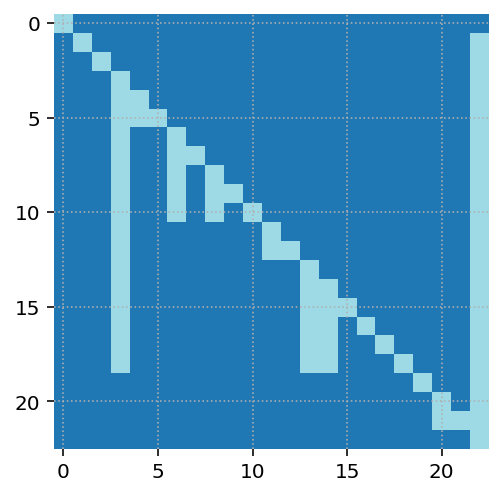

In [546]:
A = ancestor_matrix(merged_lineages)
plt.imshow(A)

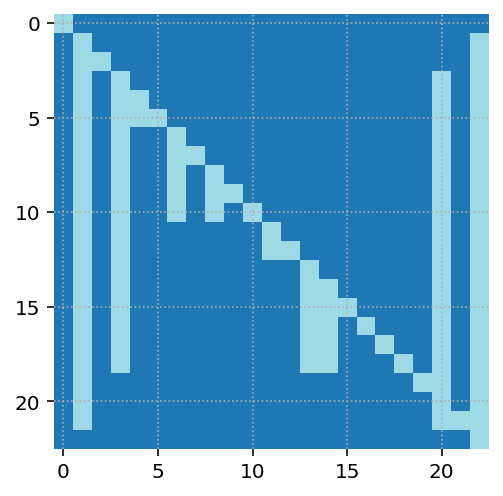

In [622]:
A[1:-1,merged_lineages.index("B.1.1.7")] = 1
A[merged_lineages.index('B.1.1.529'):-1,merged_lineages.index("B.1.617.2")] = 1
plt.imshow(A)

### Cases
Also from RKI

In [39]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [40]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-21   
                                    2020-03-13  2020-03-19   
                                    2020-03-16  2020-03-19   
            A35-A59      M          2020-03-16  2020-03-14   
...                                                    ...   
16077       A60-A79      W          2022-09-15  2022-09-15   
            A15-A34      W          2022-09-16  2022-09-16   
            A60-A79      W          2022-09-16  2022-09-16   
            A35-A59      W          2022-09-16  2022-09-16   
            A05-A14      W          2022-09-16  2022-09-16   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
            A35-A59      M          2020-03-16                     1   
...                                                              ...   
16077       A60-A79      W          2022-09-15                     0   
            A15-A34      W          2022-09-16                     0   
            A60-A79      W          2022-09-16                     0   
            A35-A59      W          2022-09-16                     0   
            A05-A14      W          2022-09-16                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
            A35-A59      M          2020-03-16          0              -9   
...                                                   ...             ...   
16077       A60-A79      W          2022-09-15          0              -9   
            A15-A34      W          2022-09-16          0              -9   
            A60-A79      W          2022-09-16          0              -9   
            A35-A59      W          2022-09-16          0              -9   
            A05-A14      W          2022-09-16          0              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
            A35-A59      M          2020-03-16           0           1   
...                                                    ...         ...   
16077       A60-A79      W          2022-09-15          -9           1   
            A15-A34      W          2022-09-16          -9           4   
            A60-A79      W          2022-09-16          -9           2   
            A35-A59      W          2022-09-16          -9           3   
            A05-A14      W          2022-09-16          -9           1   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

### Registration delays

In [145]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

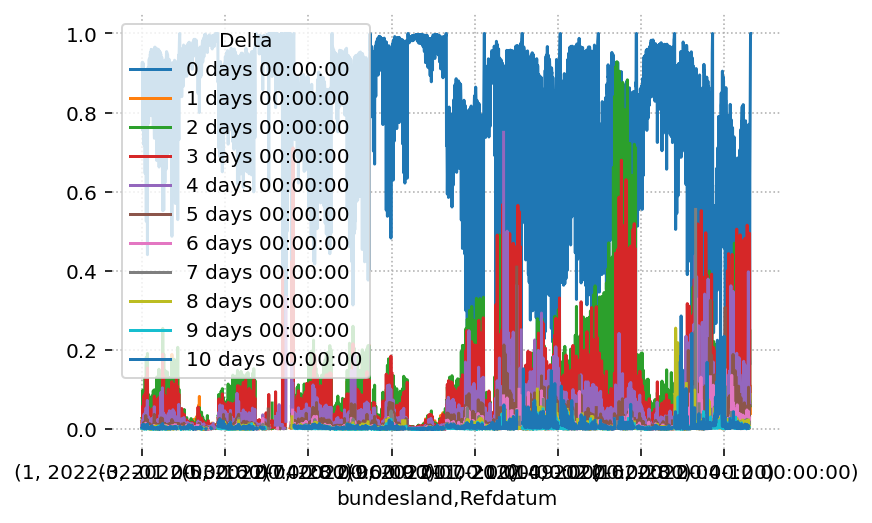

In [146]:
f.plot()

In [147]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [148]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [149]:
f.loc[1]

Delta,0 days 00:00:00,1 days 00:00:00,2 days 00:00:00,3 days 00:00:00,4 days 00:00:00,5 days 00:00:00,6 days 00:00:00,7 days 00:00:00,8 days 00:00:00,9 days 00:00:00,10 days 00:00:00
weekday,,,,,,,,,,,
Tue,0.929731,0.952122,0.976420,0.988556,0.991041,0.991794,0.995927,0.997824,0.998596,0.998792,1.0
Wed,0.929822,0.952566,0.976255,0.981238,0.983210,0.991784,0.996034,0.997818,0.998543,0.998968,1.0
Thu,0.924426,0.948679,0.957676,0.963295,0.983538,0.992858,0.996523,0.997882,0.998401,0.998355,1.0
Fri,0.916052,0.923907,0.935730,0.965334,0.984792,0.993056,0.995463,0.997151,0.997436,0.996493,1.0
Sat,0.762135,0.784239,0.865300,0.941710,0.977580,0.987767,0.992457,0.993080,0.993368,0.996085,1.0
Sun,0.670268,0.748185,0.872722,0.947537,0.974469,0.986367,0.985903,0.987211,0.992698,0.995156,1.0
Mon,0.899723,0.926747,0.963877,0.982069,0.990831,0.992706,0.993257,0.995970,0.997319,0.998304,1.0


In [150]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [151]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [152]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

,0,1,2,3,4,5,6,7,8
Baden-Württemberg,0.998418,0.998144,0.998395,0.998730,0.997879,0.994874,0.993388,0.974801,0.946690
Bayern,0.987029,0.975017,0.976970,0.969568,0.942944,0.880523,0.820463,0.597316,0.439273
Berlin,0.961599,0.867159,0.965791,0.961912,0.947427,0.906046,0.876214,0.602883,0.285551
Brandenburg,0.943645,0.907762,0.966929,0.970453,0.960628,0.947479,0.907341,0.735880,0.425958
Bremen,0.995876,0.996473,0.995746,0.992883,0.990560,0.990702,0.977676,0.959811,0.819949
Hamburg,0.994971,0.993770,0.994116,0.993684,0.991646,0.986060,0.974500,0.941905,0.938592
Hessen,0.995968,0.987526,0.993806,0.991905,0.983707,0.955978,0.946244,0.804309,0.620959
Mecklenburg-Vorpommern,0.991297,0.988360,0.991304,0.991748,0.981767,0.956765,0.901288,0.513011,0.212736
Niedersachsen,0.989774,0.974137,0.985580,0.986391,0.977363,0.958943,0.941827,0.846583,0.706867
Nordrhein-Westfalen,0.991019,0.981911,0.984562,0.980412,0.965211,0.934358,0.893340,0.749611,0.601192


In [153]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [154]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,start_date:,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,...,2022-09-09,2022-09-10,2022-09-11,2022-09-12,2022-09-13,2022-09-14,2022-09-15,2022-09-16,2022-09-17,2022-09-18
bundesland,,,,,,,,,,,,,,,,,,,,,
Baden-Württemberg,1586.0,1666.0,1663.0,2042.0,2554.0,1964.0,2064.0,2251.0,1801.0,1381.0,...,2913.0,760.0,445.0,4646.0,4851.0,3872.0,3733.0,2498.0,1.0,NaN
Bayern,2151.0,2449.0,2222.0,2908.0,3607.0,3026.0,3271.0,3584.0,2646.0,1927.0,...,4649.0,2314.0,2174.0,6758.0,7706.0,5879.0,4943.0,3868.0,NaN,1.0
Berlin,595.0,687.0,688.0,1006.0,981.0,1008.0,992.0,986.0,554.0,461.0,...,1102.0,370.0,154.0,1785.0,1571.0,1234.0,1311.0,780.0,NaN,NaN
Brandenburg,647.0,529.0,542.0,1098.0,1196.0,1092.0,1057.0,907.0,752.0,652.0,...,1084.0,227.0,139.0,1568.0,1869.0,1740.0,1279.0,845.0,NaN,1.0
Bremen,30.0,48.0,46.0,55.0,81.0,96.0,102.0,81.0,83.0,43.0,...,318.0,87.0,38.0,493.0,595.0,464.0,354.0,218.0,NaN,NaN
Hamburg,327.0,373.0,357.0,482.0,425.0,378.0,390.0,341.0,236.0,293.0,...,482.0,209.0,373.0,516.0,840.0,645.0,475.0,7.0,1.0,NaN
Hessen,1085.0,919.0,959.0,1174.0,1533.0,1719.0,1409.0,1361.0,1132.0,782.0,...,2663.0,903.0,544.0,4253.0,3742.0,3682.0,3242.0,2563.0,NaN,NaN
Mecklenburg-Vorpommern,178.0,218.0,271.0,485.0,269.0,295.0,221.0,255.0,192.0,289.0,...,678.0,79.0,298.0,1050.0,1438.0,880.0,773.0,696.0,NaN,1.0
Niedersachsen,874.0,956.0,957.0,1287.0,1505.0,1649.0,1300.0,1311.0,1189.0,731.0,...,3639.0,869.0,539.0,5510.0,6212.0,4851.0,4118.0,2243.0,NaN,1.0


In [155]:
cases_land.sum(0)

Refdatum
2021-01-01    13398.0
2021-01-02    14429.0
2021-01-03    14061.0
2021-01-04    19284.0
2021-01-05    21960.0
               ...   
2022-09-14    38263.0
2022-09-15    33689.0
2022-09-16    21673.0
2022-09-17        3.0
2022-09-18        8.0
Length: 626, dtype: float64

In [156]:
clip = 2
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

Refdatum,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,...,2022-09-07,2022-09-08,2022-09-09,2022-09-10,2022-09-11,2022-09-12,2022-09-13,2022-09-14,2022-09-15,2022-09-16
bundesland,,,,,,,,,,,,,,,,,,,,,
Baden-Württemberg,1586.0,1666.0,1663.0,2042.0,2554.0,1964.0,2064.0,2251.0,1801.0,1381.0,...,3504.0,3164.0,2913.0,761.204007,445.827409,4653.470628,4857.169314,3880.230612,3752.232848,2514.627333
Bayern,2151.0,2449.0,2222.0,2908.0,3607.0,3026.0,3271.0,3584.0,2646.0,1927.0,...,5598.0,4949.0,4649.0,2344.408414,2229.704176,6917.304164,7947.868689,6234.727619,5613.706059,4714.411964
Berlin,595.0,687.0,688.0,1006.0,981.0,1008.0,992.0,986.0,554.0,461.0,...,1356.0,1170.0,1102.0,384.775743,177.591353,1848.225842,1633.206243,1302.475307,1446.946753,890.193840
Brandenburg,647.0,529.0,542.0,1098.0,1196.0,1092.0,1057.0,907.0,752.0,652.0,...,1592.0,1448.0,1084.0,240.556601,153.123762,1621.629470,1925.904082,1811.315726,1349.898702,931.292247
Bremen,30.0,48.0,46.0,55.0,81.0,96.0,102.0,81.0,83.0,43.0,...,387.0,253.0,318.0,87.360248,38.134494,495.105951,599.264908,468.421830,357.322458,222.977828
Hamburg,327.0,373.0,357.0,482.0,425.0,378.0,390.0,341.0,236.0,293.0,...,738.0,452.0,482.0,210.056324,375.338518,519.053999,845.339541,650.433485,481.715305,7.183170
Hessen,1085.0,919.0,959.0,1174.0,1533.0,1719.0,1409.0,1361.0,1132.0,782.0,...,3097.0,2801.0,2663.0,906.655346,550.871668,4279.506708,3772.537738,3742.985251,3391.290412,2708.604358
Mecklenburg-Vorpommern,178.0,218.0,271.0,485.0,269.0,295.0,221.0,255.0,192.0,289.0,...,743.0,813.0,678.0,79.693534,301.509486,1059.211280,1449.965132,896.342949,807.931060,772.228186
Niedersachsen,874.0,956.0,957.0,1287.0,1505.0,1649.0,1300.0,1311.0,1189.0,731.0,...,4762.0,3941.0,3639.0,877.978024,553.310048,5590.616373,6297.707599,4963.357907,4294.310760,2381.542398


In [157]:
C = cases_land.values

### Population data
From Destatis

In [54]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [55]:
131 % 10

1

## Modeling
### Basis functions

In [158]:
from genomicsurveillance.misc import fused_basis
n = C.shape[1]+clip 
inc = 10
B0 = fused_basis(n+2, inc=inc, fuse=5, pad=35 - n % inc) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 
#B0 = fused_basis(n+2, inc=7, fuse=5, pad=30 - n % 7)## cubic spline basis every 7d, last 5 linearly fused to avoid wriggles 
B0 = np.stack([B0[0,2:,:],B0[1,:-2,:]])
#B0 = B0[:,:-(inc-n%inc)][:,-n:]

In [159]:
B0.shape

(2, 626, 66)

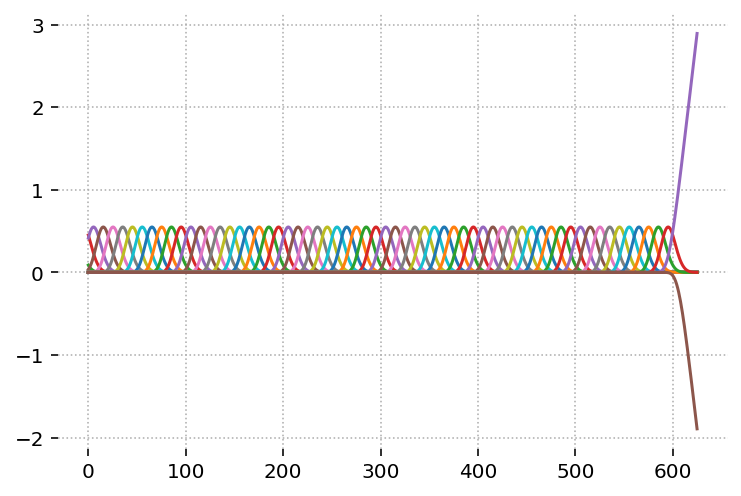

In [160]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

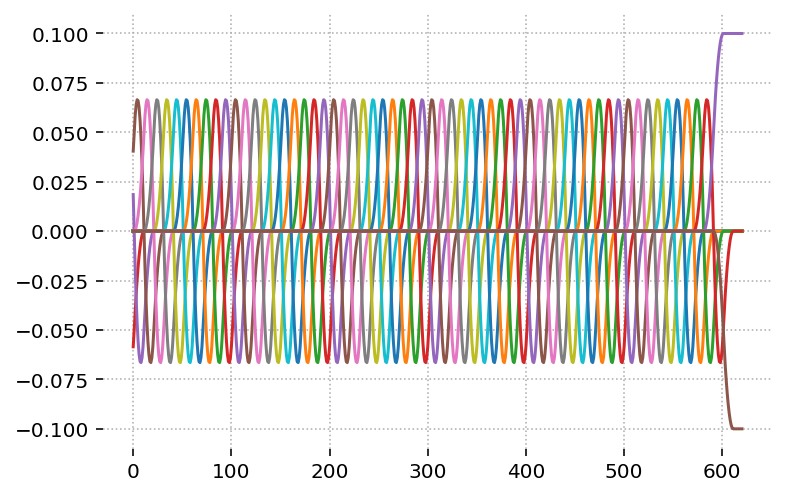

In [161]:
for i in range(B0.shape[-1]):
    plt.plot(B0[1,:-5,i])

In [162]:
np.sum(np.diff(B0[1,-30:,-1])+1 == 1)

10

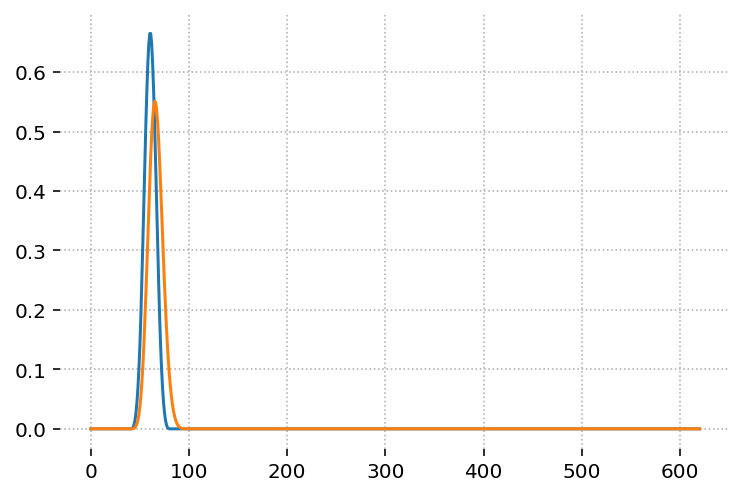

In [163]:
plt.plot(B0[1,:-5,10].cumsum())
plt.plot(B0[0,:-5,10])


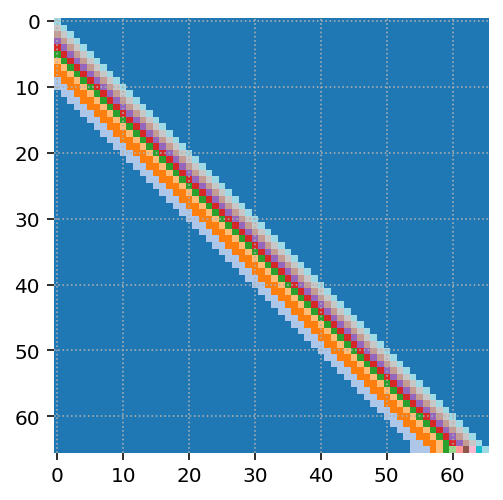

In [164]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.75
arma2[-1,-2] = -.9
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

### Case and genome data
Prepare as arrays and add Germany as a whole

In [547]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [576]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, alias

In [577]:
from numpyro.infer import Trace_ELBO

In [598]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

In [599]:
CC[2,cases_land.columns == np.datetime64("2022-03-08")] = np.nan # int women's day in Berlin..
#GG[-1, genomes.index.levels[1] <= "2022-07-15", merged_lineages_alias.index("BA.2.75")] = 0
GG[:, genomes.index.levels[1] < "2022-02-01", merged_lineages_alias.index("BA.5")] = 0 # Some erroneous BA.5
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B")] = 0 # Issues with spurious B lineages later on
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B.1.1.7")] = 0 # Issues with spurious B lineages later on
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B.1.351")] = 0 # Issues with spurious B lineages later on
GG[:, (genomes.index.levels[1] < "2021-11-01").reshape(-1,1) * np.array([x.startswith("B.1.1.529") for x in merged_lineages]).reshape(1,-1)] = 0
GG[:, (genomes.index.levels[1] < "2021-04-01").reshape(-1,1) * np.array([x.startswith("B.1.617.2") for x in merged_lineages]).reshape(1,-1)] = 0

In [600]:
GG[:, genomes.index.levels[1] <= "2021-04-01"][:,:,[x.startswith("B.1.617.2") for x in merged_lineages]].sum()

0.0

In [601]:
x = (GG[-1].cumsum(0)>0).argmax(0)
dict(zip(merged_lineages, x))

{'A': 5,
 'B.1.1.7': 1,
 'B.1.1.28.1': 33,
 'B.1.1.529': 348,
 'B.1.1.529.1': 326,
 'B.1.1.529.1.1': 320,
 'B.1.1.529.2': 336,
 'B.1.1.529.2.12.1': 458,
 'B.1.1.529.2.75': 518,
 'B.1.1.529.2.75.1': 541,
 'B.1.1.529.2.75.2': 579,
 'B.1.1.529.4': 415,
 'B.1.1.529.4.6': 489,
 'B.1.1.529.5': 429,
 'B.1.1.529.5.2': 419,
 'B.1.1.529.5.2.1.7': 528,
 'B.1.1.529.5.2.1.11': 543,
 'B.1.1.529.5.2.1.13': 572,
 'B.1.1.529.5.2.1.14': 553,
 'B.1.351': 4,
 'B.1.617.2': 94,
 'B.1.617.2.4': 100,
 'B': 0}

### Model
Multi-lineage model with variable growth rates (random effect) across states

In [633]:
model = MultiLineageTimeShift(
    CC[[-1]],
    GG[[-1]],    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)])[[-1]],
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    #b_scale=0.01,
    b0_scale=0.3,
    #c_scale=30,
    c0_scale=5,
    c0_loc=-10,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.001,#.001,
    alpha1=1000., 
    week=True,
    fit_logits=False,#True,
    ancestor_matrix=A,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=100), 'num_epochs':2000, 'lr':0.03, 'lrd': 0.1 ** (1/2000), 'num_samples': 100, 'log_freq':200}

)

In [634]:
model.fit(num_epochs=1000)

SVI step 0 / 1,000 | 0 %
SVI step 200 / 1,000 | 20 %
SVI step 400 / 1,000 | 40 %
SVI step 600 / 1,000 | 60 %
SVI step 800 / 1,000 | 80 %


(0.0, 1000000.0)

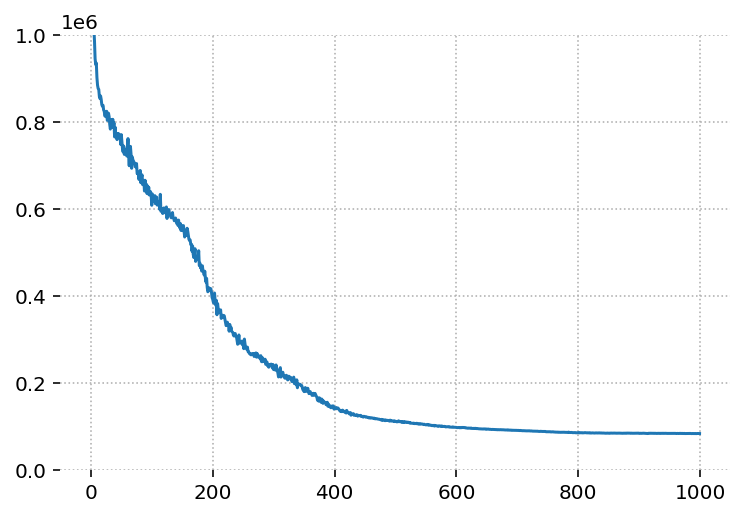

In [635]:
plt.plot(model.loss)
plt.ylim((0,1e6))

Text(0, 0.5, 'ELBO')

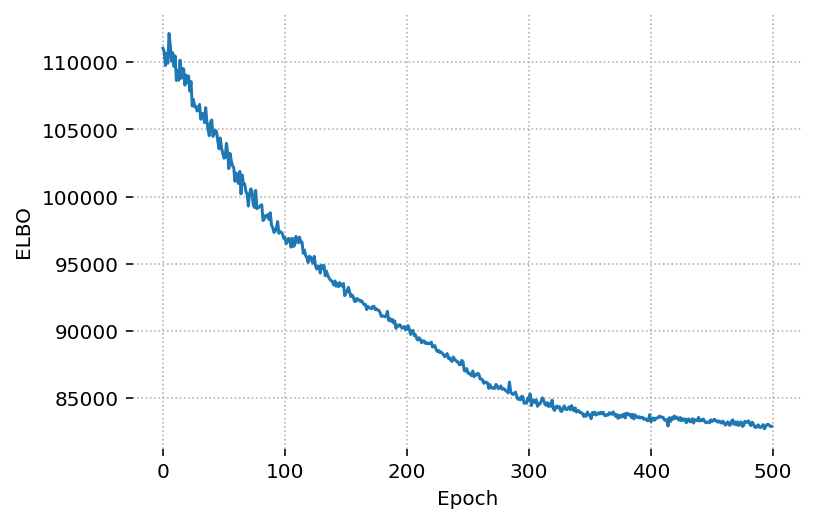

In [640]:
plt.plot(model.loss[500:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

Text(0, 0.5, 'ELBO')

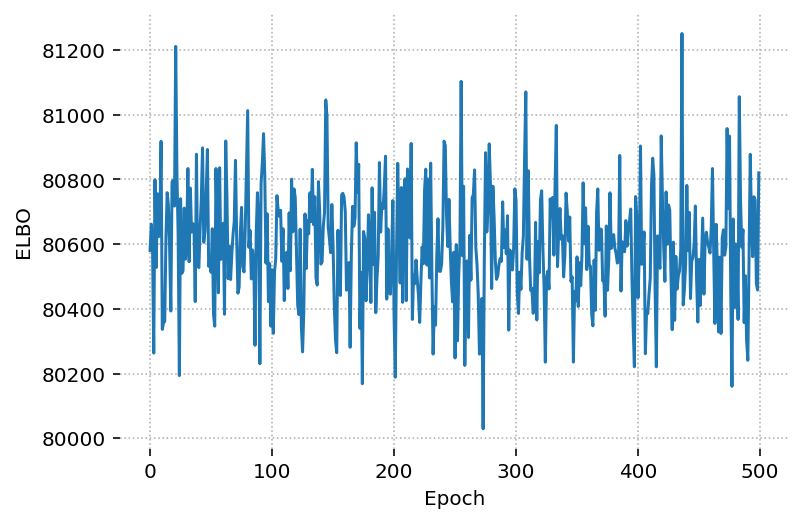

In [642]:
plt.plot(model.loss[1500:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [641]:
model.fit(num_epochs=1000)

SVI step 0 / 1,000 | 0 %
SVI step 200 / 1,000 | 20 %
SVI step 400 / 1,000 | 40 %
SVI step 600 / 1,000 | 60 %
SVI step 800 / 1,000 | 80 %


Text(0, 0.5, 'ELBO')

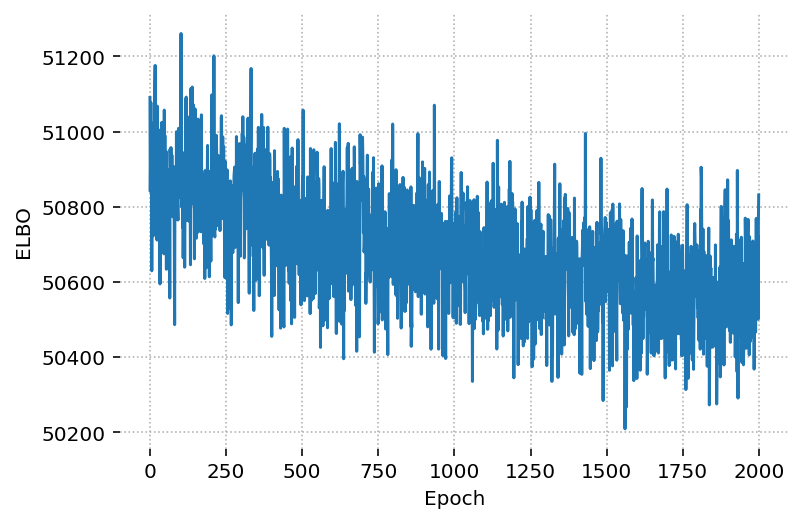

In [533]:
plt.plot(model.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((model.loss[2000],model.loss[1200]))

In [534]:
lineage_colors = {'B.1.1.529':'C7',
                 'BA.1': 'rebeccapurple',#'mistyrose', #
                 'BA.1.1': 'C4',#"lavender", #
                 'BA.2':"C1", 
                 'BA.2.12.1':"C6",
                 'BA.2.75':"orangered",
                  'BA.2.75.1':"salmon",
                  'BA.2.75.2':"C3",
                 'BA.4':"C8",
                 'BA.4.6': 'peru',
                 'BA.5':"C9",
                  'BA.5.2': 'darkcyan',
                  "BF.7":"limegreen",
                  'BF.11':"C2",
                  'BF.13':"yellowgreen",
                  'BF.14':'green',
                 'Other':"C7",
                 'B.1.617.2': 'C0',
                 'AY.4': 'cornflowerblue',
                  'A': 'lightgrey',
                  'B': 'lightgrey',
                  'B.1.1.7': 'navy' ,
                  'B.1.351': 'black',
                  'P.1' : 'slategrey'
                 } #"aliceblue"}

In [398]:
merged_lineages_alias = [alias(x) for x in merged_lineages]

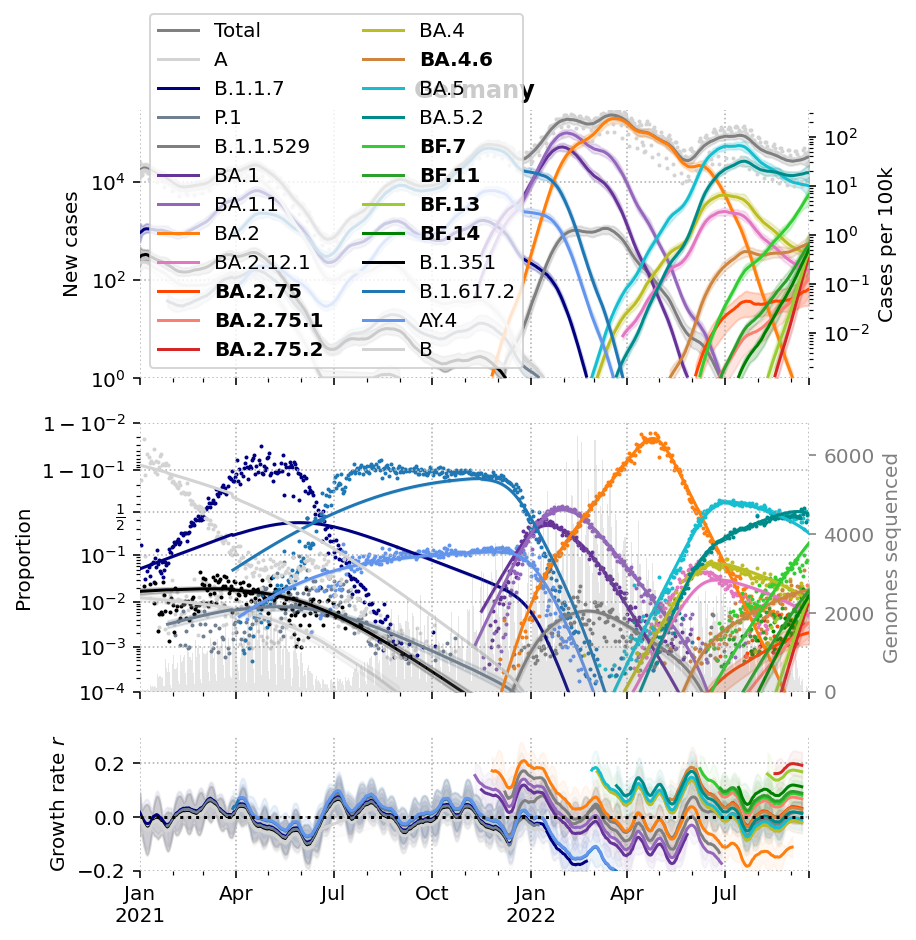

In [643]:
#from genomicsurveillance.plots.england import plot_lad, 
plt.rcParams['font.sans-serif'] = ["DejaVu Sans"]
from matplotlib import gridspec
from genomicsurveillance.plots.england import plot_median_and_ci
#from matplotlib import rc
#rc('text', usetex=False)
for i,r in [(-1, "Germany")]:#enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 3)[0]
    #w = list(set(w) - set([0,GG.shape[2]-2]))
    #w = [w[-1]] + w[:-1]
    #plt.set_cmap("tab20")
    col = [lineage_colors[x] for x in merged_lineages_alias]
    plot_lad(model, i, CC, GG, seq_index, start_date=start_date, show_start_date=start_date,
        lin = w,
        labels = np.array(merged_lineages_alias)[w], #[x if not x in ["BA.2.75", "BA.4.6","BA.5.2.1.7","BA.5.2.1.11"] else r"$\bf{"+x+"}$" for x in merged_lineages_alias])[w],#genomes.columns[w],
        #lin_colors=np.array(5*['C7','C3',"C4","C1", "C6","C8" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
        lin_colors=np.array(5*col)[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
             lin_marker=".",
             lin_marker_size=2,
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    ax[0].set_yscale('log')
    ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[0].set_ylim((None, np.nanmax(CC[i,:])))
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-4,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    for i in range(3):
        ax[i].set_position(gridspec.GridSpec(3, 1, height_ratios=[1,1, 0.5])[i].get_position(plt.gcf()))
    #ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")
    leg = ax[0].legend(loc="lower left", ncol=2)
    for l in leg.get_texts():
        if re.match("|".join(["BA.2.75", "BA.4.6","BF"]),l.get_text()):
            l.set_weight('bold')
    plt.gcf().set_size_inches(6,7)

b = np.array(model.posterior['b1'])
b[b==0] = np.nan
b[...,-1]= 0
r = pd.DataFrame((b - b[...,[1]]).mean((0,2)), columns=merged_lineages_alias, index=["Germany"])# cases_land.index.to_list() + ["Germany"])

In [75]:
r

,B.1.1.529,BA.1,BA.1.1,BA.2,BA.2.12.1,BA.2.75,BA.2.75.1,BA.2.75.2,BA.4,BA.4.6,BA.5,BA.5.2,BF.7,BF.11,BF.13,BF.14,Other,B.1.617.2
Germany,0.059449,0.0,0.024999,0.093229,0.153669,0.24858,0.263512,0.279477,0.181426,0.233114,0.198132,0.216793,0.252397,0.243439,0.247737,0.283097,0.11029,-0.135549


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18]),
 [Text(1, 0, 'B.1.1.529'),
  Text(2, 0, 'BA.1'),
  Text(3, 0, 'BA.1.1'),
  Text(4, 0, 'BA.2'),
  Text(5, 0, 'BA.2.12.1'),
  Text(6, 0, 'BA.2.75'),
  Text(7, 0, 'BA.2.75.1'),
  Text(8, 0, 'BA.2.75.2'),
  Text(9, 0, 'BA.4'),
  Text(10, 0, 'BA.4.6'),
  Text(11, 0, 'BA.5'),
  Text(12, 0, 'BA.5.2'),
  Text(13, 0, 'BF.7'),
  Text(14, 0, 'BF.11'),
  Text(15, 0, 'BF.13'),
  Text(16, 0, 'BF.14'),
  Text(17, 0, 'Other'),
  Text(18, 0, 'B.1.617.2')])

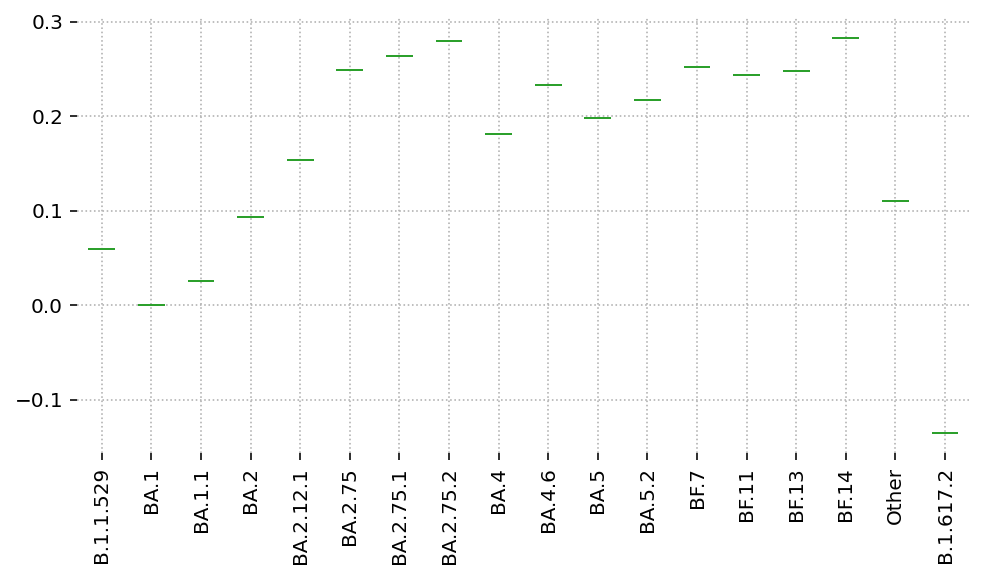

In [76]:
#r[r==0] = np.nan
plt.figure(figsize=(8,4))
r.boxplot(figsize=(8,4))
plt.xticks(rotation=90)
#r.mean(0).plot(ls="", marker=".")


In [77]:
import re

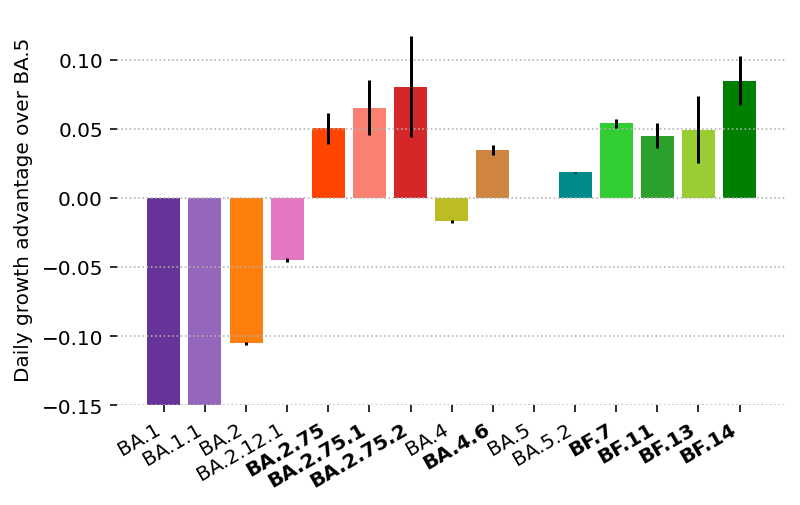

[Text(0, 0, 'BA.1'), Text(1, 0, 'BA.1.1'), Text(2, 0, 'BA.2'), Text(3, 0, 'BA.2.12.1'), Text(4, 0, 'BA.2.75'), Text(5, 0, 'BA.2.75.1'), Text(6, 0, 'BA.2.75.2'), Text(7, 0, 'BA.4'), Text(8, 0, 'BA.4.6'), Text(9, 0, 'BA.5'), Text(10, 0, 'BA.5.2'), Text(11, 0, 'BF.7'), Text(12, 0, 'BF.11'), Text(13, 0, 'BF.13'), Text(14, 0, 'BF.14')]


In [78]:
baseline = "BA.5"
s = pd.DataFrame((b - b[...,[merged_lineages_alias.index(baseline)]]).mean((2))[:,-1], columns=merged_lineages_alias).iloc[:,1:-2]
#s.boxplot()
plt.figure(figsize=(6,4))
plt.bar(s.columns, s.iloc[:-1,:].mean(), yerr=2*s.std(), color=[lineage_colors[x] for x in s.columns])
#plt.ylim((-0.15,0.2))
plt.ylim((-0.15,None))
#plt.draw()
#lt.xticks(rotation=45)
plt.ylabel(f"Daily growth advantage over {baseline}")
plt.grid(False)
plt.grid(axis="y")
plt.gcf().autofmt_xdate()
plt.draw()
xl = plt.gca().get_xticklabels()
for l in xl:
    if re.match("|".join(["BA.2.75", "BA.4.6","BF"]),l.get_text()):
        l.set_weight('bold')
plt.show()
print(xl)

In [79]:
q=(0.025,0.5,0.975)
pd.DataFrame(np.quantile(model.get_probabilities()[:,0,-1:,:], q, 0).squeeze(), index=np.array(q), columns=merged_lineages_alias)

,B.1.1.529,BA.1,BA.1.1,BA.2,BA.2.12.1,BA.2.75,BA.2.75.1,BA.2.75.2,BA.4,BA.4.6,BA.5,BA.5.2,BF.7,BF.11,BF.13,BF.14,Other,B.1.617.2
0.025,2.293684e-11,7.197278e-15,4.364939e-12,0.000009,0.000352,0.002164,0.001367,0.001214,0.007838,0.016510,0.329088,0.494218,0.089109,0.004207,0.000783,0.004833,5.098276e-07,7.261477e-30
0.500,9.380170e-11,9.422579e-15,5.291950e-12,0.000010,0.000421,0.003566,0.002953,0.002882,0.008729,0.019737,0.337718,0.504574,0.100833,0.006787,0.002214,0.008678,7.329745e-07,8.048760e-30
0.975,2.919474e-10,1.227136e-14,6.260095e-12,0.000011,0.000480,0.005767,0.005190,0.008133,0.009271,0.023580,0.346912,0.515535,0.111139,0.011242,0.004500,0.015108,1.027332e-06,8.819404e-30


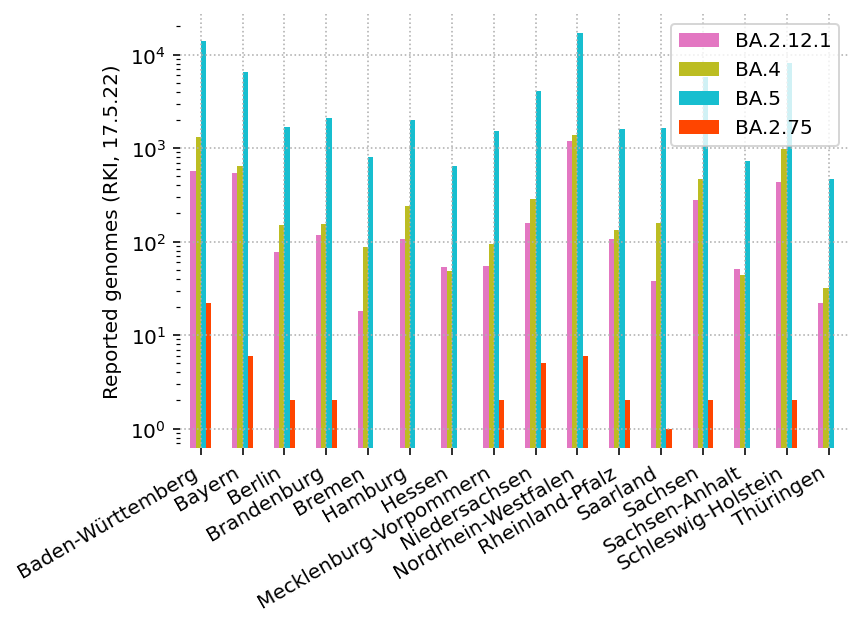

In [80]:
w = ["BA.2.12.1","BA.4","BA.5","BA.2.75"]
f.iloc[:-1,:].loc[:,w].plot.bar(color=[lineage_colors[x] for x in w])
plt.ylabel("Reported genomes (RKI, 17.5.22)")
plt.xticks(rotation=30, ha='right')
plt.yscale('log')

In [81]:
model.posterior['b1'].mean(0)[-1,0,:]

array([0.1949979 , 0.13554922, 0.16054814, 0.2287777 , 0.28921825,
       0.38412967, 0.39906156, 0.41502663, 0.3169752 , 0.36866364,
       0.3336814 , 0.3523423 , 0.38794586, 0.3789881 , 0.38328603,
       0.41864586, 0.24583876, 0.        ], dtype=float32)

In [82]:
f = model.params['bc0_loc'].reshape(2,-1)[0,:]/100
f = np.append(f, -A[-1,:-1] @ f / A[-1,-1])
A @ f

array([0.19465663, 0.13550154, 0.16056283, 0.2287508 , 0.2893355 ,
       0.3835169 , 0.39989366, 0.41131731, 0.31702363, 0.36835057,
       0.33365192, 0.35232091, 0.38781723, 0.37921357, 0.38429857,
       0.41822253, 0.24593437, 0.        ])

In [83]:
pd.Series(np.diff(model.get_logits().mean(0)[-1,-2:,:], axis=0)[0], index=merged_lineages)

B.1.1.529             0.195000
B.1.1.529.1           0.135551
B.1.1.529.1.1         0.160549
B.1.1.529.2           0.228790
B.1.1.529.2.12.1      0.289219
B.1.1.529.2.75        0.384129
B.1.1.529.2.75.1      0.399059
B.1.1.529.2.75.2      0.415028
B.1.1.529.4           0.316975
B.1.1.529.4.6         0.368660
B.1.1.529.5           0.333679
B.1.1.529.5.2         0.352348
B.1.1.529.5.2.1.7     0.387939
B.1.1.529.5.2.1.11    0.378990
B.1.1.529.5.2.1.13    0.383289
B.1.1.529.5.2.1.14    0.418644
Other                 0.245838
B.1.617.2             0.000000
dtype: float32

In [84]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

1.0

In [85]:
model.posterior.keys()

dict_keys(['b1', 'bc0', 'beta1', 'c1', 't', 'b0'])

In [86]:
λ = np.median(model.get_lambda_lineage(),0) / model.population[:,np.newaxis, np.newaxis]

In [87]:
λ.shape

(1, 322, 18)

In [88]:
λ[-1,-1]/λ[-1,-1].sum()

array([8.80196314e-11, 9.30242941e-15, 5.25696280e-12, 9.76543356e-06,
       4.18071047e-04, 3.54632104e-03, 2.76145021e-03, 2.85916934e-03,
       8.71302360e-03, 2.02113116e-02, 3.38251664e-01, 5.06082956e-01,
       9.96580657e-02, 6.77495558e-03, 2.27996585e-03, 8.43253641e-03,
       7.44810768e-07, 8.00711720e-30])

In [89]:
merged_lineages_alias

['B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'Other',
 'B.1.617.2']

In [90]:
λ[-1,-1] / λ[-1,-1].sum()

array([8.80196314e-11, 9.30242941e-15, 5.25696280e-12, 9.76543356e-06,
       4.18071047e-04, 3.54632104e-03, 2.76145021e-03, 2.85916934e-03,
       8.71302360e-03, 2.02113116e-02, 3.38251664e-01, 5.06082956e-01,
       9.96580657e-02, 6.77495558e-03, 2.27996585e-03, 8.43253641e-03,
       7.44810768e-07, 8.00711720e-30])

In [91]:
from genomicsurveillance.misc import get_transmissibility

In [92]:
GG.shape

(17, 319, 18)

In [421]:
d = model.posterior['bc0'].mean(0).squeeze()[:GG.shape[-1]-1]

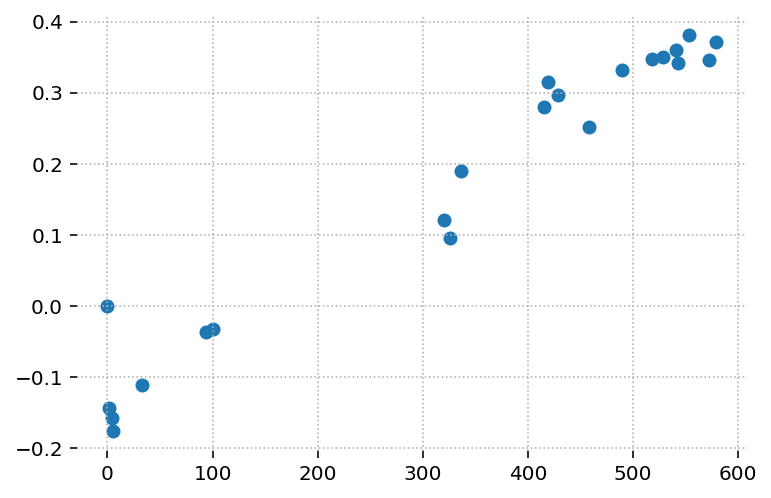

In [422]:
x = (GG[-1].cumsum(0)>0).argmax(0)
r = b.squeeze().mean(0)
plt.scatter(x, r)

In [596]:
x = (GG[-1].cumsum(0)>0).argmax(0)
y = (-GG[-1]).cumsum(0).argmin(0)
dict(zip(merged_lineages_alias, genomes.index.levels[1][y]))

{'A': Timestamp('2021-06-21 00:00:00'),
 'B.1.1.7': Timestamp('2022-03-15 00:00:00'),
 'P.1': Timestamp('2021-10-22 00:00:00'),
 'B.1.1.529': Timestamp('2022-06-30 00:00:00'),
 'BA.1': Timestamp('2022-09-06 00:00:00'),
 'BA.1.1': Timestamp('2022-07-21 00:00:00'),
 'BA.2': Timestamp('2022-09-09 00:00:00'),
 'BA.2.12.1': Timestamp('2022-09-06 00:00:00'),
 'BA.2.75': Timestamp('2022-09-16 00:00:00'),
 'BA.2.75.1': Timestamp('2022-09-16 00:00:00'),
 'BA.2.75.2': Timestamp('2022-09-15 00:00:00'),
 'BA.4': Timestamp('2022-09-16 00:00:00'),
 'BA.4.6': Timestamp('2022-09-15 00:00:00'),
 'BA.5': Timestamp('2022-09-16 00:00:00'),
 'BA.5.2': Timestamp('2022-09-16 00:00:00'),
 'BF.7': Timestamp('2022-09-16 00:00:00'),
 'BF.11': Timestamp('2022-09-12 00:00:00'),
 'BF.13': Timestamp('2022-09-08 00:00:00'),
 'BF.14': Timestamp('2022-09-12 00:00:00'),
 'B.1.351': Timestamp('2022-03-15 00:00:00'),
 'B.1.617.2': Timestamp('2022-09-06 00:00:00'),
 'AY.4': Timestamp('2022-04-19 00:00:00'),
 'B': Timestamp

In [424]:
f = np.einsum("...l,...l", model.get_probabilities(), b).squeeze()

In [425]:
r = b.squeeze()
from adjustText import adjust_text

In [426]:
r.shape

(100, 22)

In [427]:
f.shape

(100, 626)

In [428]:
r.shape

(100, 22)

500

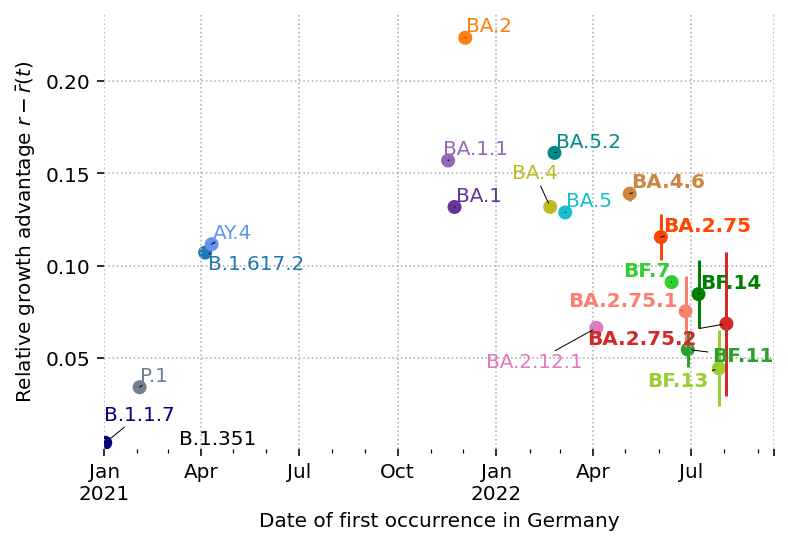

In [433]:
x = (GG[-1].cumsum(0)>0).argmax(0)
pd.Series(np.nan, index=cases_land.columns).plot()
df = pd.DataFrame({"Growth advantage to Delta":r.mean(), "Relative growth advantage f":(r-f[:,x]).mean(0), "Lineage":merged_lineages_alias},index=cases_land.columns[x]).iloc[1:-1,:]
df["Relative growth advantage f"].plot(ls="")
plt.errorbar(df.index, df["Relative growth advantage f"], yerr=2*(r-f[:,x]).std(0)[1:-1], ls="", c=[lineage_colors[x] for x in df.Lineage])
plt.scatter(df.index, df["Relative growth advantage f"], marker='o', c=[lineage_colors[x] for x in df.Lineage])
for i in range(df.shape[0]):
    j = merged_lineages_alias.index(df.Lineage[i])
    #plt.plot(cases_land.columns[x[j]] + np.arange(f.shape[1]-x[j]).astype("timedelta64[D]"), (r[:,[j]]-f[:,x[j]:]).mean(0), c=lineage_colors[df.Lineage[i]], ls="-", alpha=0.2)
text=[]
for x,y,s in zip(df.index.tolist(), df["Relative growth advantage f"],df.Lineage.tolist()):
    text.append(plt.text(x,y,s, ha='left', va='center', color=lineage_colors[s]))
plt.xlabel("Date of first occurrence in Germany")
#plt.xlabel('')
plt.ylabel("Relative growth advantage $r-\\bar{r}(t)$")
for l in text:
    if re.match("|".join(["BA.2.75", "BA.4.6","BF"]),l.get_text()):
        l.set_weight('bold')
plt.ylim((0.001,None))
#secax = plt.gca().secondary_yaxis('right', functions=(lambda x: np.log(2)/x, lambda x: 1/np.log(2)/x))
#secax.set_ylabel('Doubling time')
#secax.set_yscale('log')
#secax.set_yticks(np.concatenate([np.arange(50,10,-10),np.arange(10,1,-1)]))
#secax.spines['right'].set_visible(False)
adjust_text(text, 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), )

In [103]:
0.2/250

0.0008

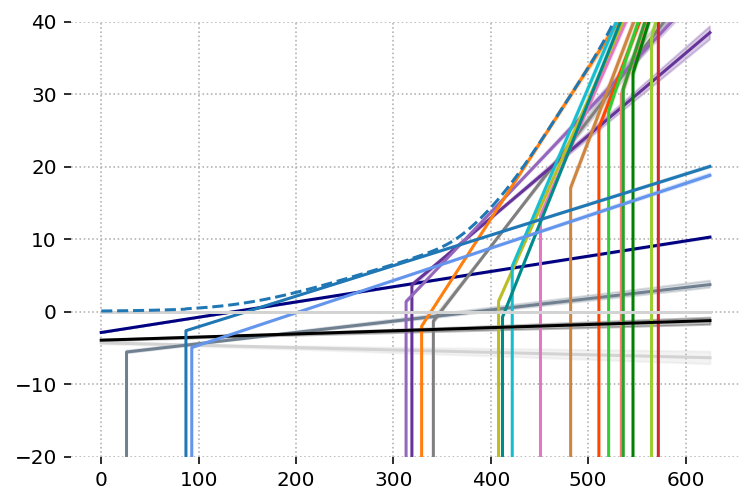

In [638]:
l = model.get_logits(ltla=-1).squeeze()
#m = 0.5 * (((r-r[0])/x)[:-1].mean()) * np.arange(l.shape[1])**2 + r[1]*np.arange(l.shape[1]) - 15#np.max(np.mean(l,0),-1)
for i in range(l.shape[-1]):
    plt.plot(np.mean(l[...,i],0), c=lineage_colors[merged_lineages_alias[i]])
    plt.fill_between(x=np.arange(l.shape[1]), y1=np.quantile(l[...,i],0.05, 0), y2=np.quantile(l[...,i],0.95, 0), color=lineage_colors[merged_lineages_alias[i]], alpha=0.25)
plt.ylim((-20,40))
#l.shape
#plt.plot(seq_index, 0.5 * 0.0008 * seq_index**2)

from scipy.special import logsumexp
plt.plot(logsumexp(l.mean(0).squeeze(), -1), ls="--")


#plt.plot(np.max(np.mean(l,0),-1))

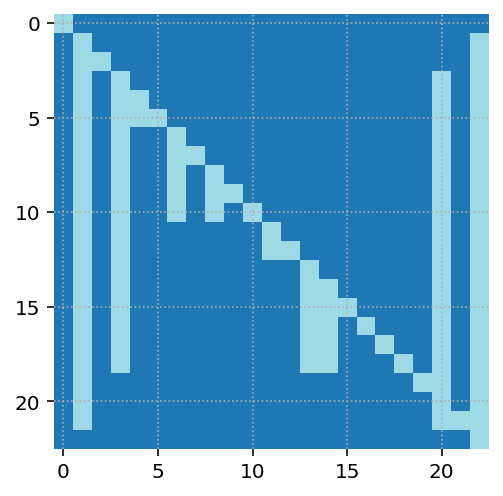

In [639]:
plt.imshow(model.ancestor_matrix)

In [105]:
np.mean(model.posterior['c1'].squeeze(),0)

array([-11.539365 ,  -6.7963285,  -9.068922 , -12.284699 ,  -6.8347654,
       -11.83394  ,  -9.810264 ,  -4.2364287, -13.460727 , -12.387198 ,
       -11.381216 , -16.384243 ,  -7.3166447,  -6.8315983,  -3.879039 ,
        -8.219076 , -25.564802 ,   0.       ], dtype=float32)

In [106]:
np.max(np.mean(l,0),-1).shape

(322,)

In [107]:
np.where(((model.clock()[0]==0) * (model.clock()[1]==0)).squeeze().T)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 51,  29,  23,  39, 161, 221, 244, 282, 118, 192, 132, 122, 231,
        246, 275, 256,  16,   7]))

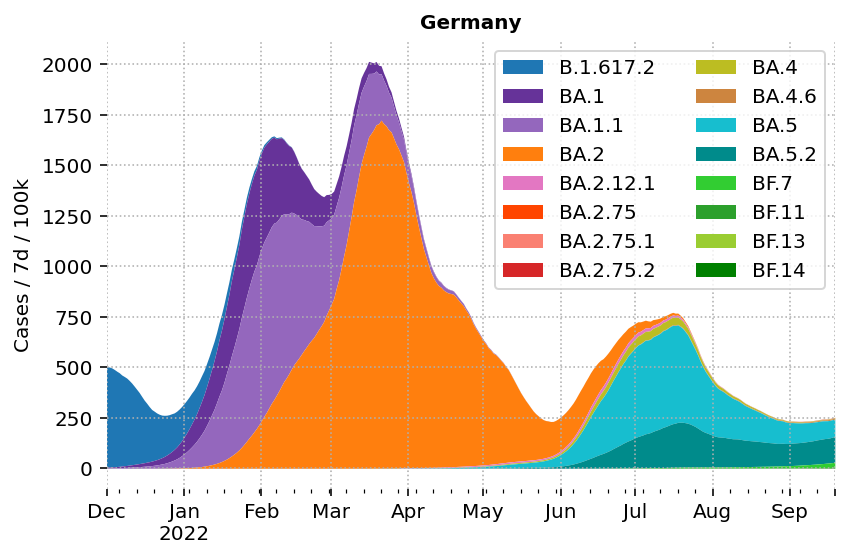

In [108]:
fig, ax = plt.subplots(1,1, figsize=(6,4), sharex=True, sharey=True)
ax = [ax]
#ax = ax.flatten()
#col = ['C7','C3',"C4","C1", "C6","C5","C8" ,"C9", "C7","C0"]
#labels =[alias(x) for x in merged_lineages]
col = lineage_colors #dict(zip(labels, col))
for i,r in enumerate(["Germany"]):
    y = pd.DataFrame(λ[i,:,:], columns=lineage_colors.keys(), index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]-1,-1,-1):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None, ncol=2)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [109]:
λ.sum()

0.34282812791838857

In [110]:
j

0

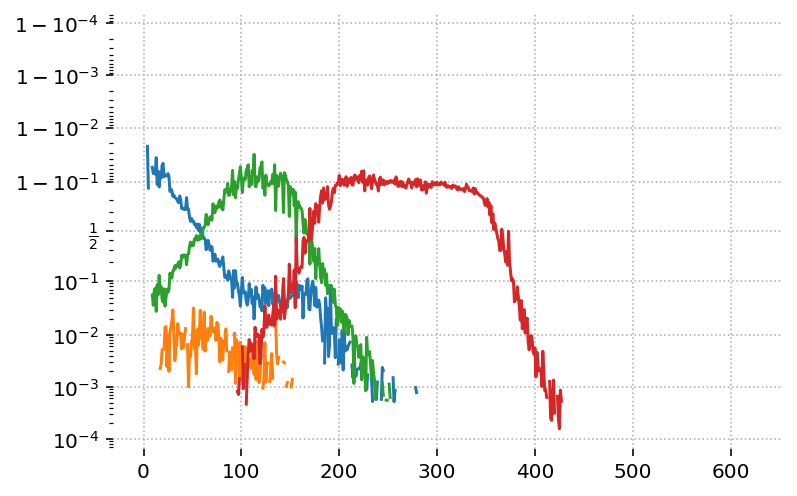

In [610]:
plt.plot(GG[-1,:,-1]/GG[-1].sum(-1))
plt.plot(GG[-1,:,0]/GG[-1].sum(-1))
plt.plot(GG[-1,:,1]/GG[-1].sum(-1))
plt.plot(GG[-1,:,-3]/GG[-1].sum(-1))
plt.yscale('logit')

In [613]:
dict(zip(merged_lineages_alias,model.posterior['b0'].squeeze().mean(0)))

{'A': -0.00320443,
 'B.1.1.7': 0.021042787,
 'P.1': 0.015508879,
 'B.1.1.529': 0.16511011,
 'BA.1': -0.053103358,
 'BA.1.1': 0.028727105,
 'BA.2': 0.043100227,
 'BA.2.12.1': 0.09904888,
 'BA.2.75': 0.15460639,
 'BA.2.75.1': 0.03469579,
 'BA.2.75.2': 0.1561663,
 'BA.4': 0.14065635,
 'BA.4.6': 0.05068351,
 'BA.5': 0.15442845,
 'BA.5.2': 0.021121033,
 'BF.7': 0.07009291,
 'BF.11': 0.07812954,
 'BF.13': 0.15610215,
 'BF.14': 0.100156456,
 'B.1.351': 0.0043954514,
 'B.1.617.2': 0.0420943,
 'AY.4': 0.002455271}

In [575]:
1/(1+np.exp(-2))

0.8807970779778823